In [1]:
from NeuroTools.parameters import ParameterSet
from NeuroTools.parameters import ParameterRange
from NeuroTools.parameters import ParameterSpace
import numpy as np
import striatum as st
import params_control as sham
import params_pd as pd
import params_pd_GluInh as pdr
import params_control_Glu as glu
import nest
import matplotlib.pyplot as plt
import pandas as pds
import os
import pickle


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug  5 2024 04:47:19

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [14]:
output_dir = '/Users/peirui/code/striatum-microcircuit/Fig1/output/'
os.makedirs(output_dir, exist_ok=True)
#run simualation
def run_simulation(sim_num,parms):
    for i in range(1,sim_num+1):
        nest.ResetKernel()
        id = i
        st.run(parms.get_parameters(),id,output_dir)

In [15]:
#run_simulation(3,sham)
#run_simulation(3,pd)
run_simulation(3,pdr)
#run_simulation(3,glu)

In [2]:
def load_data(parms_set,output_dir):
    '''
    load pickle data and organize into dict
    parms_set: different types of parameters sets 
    Control;PD;PD_GluInh';Ctl_Glu
    '''
    data_dict_spk = {'ts_d1': [], 'ts_d2': []}
    data_dict_lfp = {
        'd1_times': [], 'd1_g_ex': [], 'd1_g_in': [], 'd1_V_m': [],
        'd2_times': [], 'd2_g_ex': [], 'd2_g_in': [], 'd2_V_m': []
    }
    # Load and process the output
    for filename in os.listdir(output_dir):
        char = filename.split('_')
        if char[1]==parms_set:
            category, subtype = char[0], char[3]
            filepath = os.path.join(output_dir, filename)

            # Load the pickle file
            with open(filepath, "rb") as file:
                evs = pickle.load(file)

            # Process 'spk' data
            if category == 'spk' and subtype in ['d1', 'd2']:
                ts = evs['events']['times']
                data_dict_spk[f'ts_{subtype}'].append(ts)

            # Process 'lfp' data
            if category == 'lfp' and subtype in ['d1', 'd2']:
                for key in ['times', 'g_ex', 'g_in', 'V_m']:
                    data_dict_lfp[f'{subtype}_{key}'].append(evs[key])
    return data_dict_spk,data_dict_lfp

In [4]:
def proecess_data_spk_firing(data_dict_spk,start_time,end_time,msn_size):
 '''
 Calculate the mean firing rate of D1 and D2 MSNs.
    
  Parameters:
  data_dict_spk (dict): Dictionary containing spike times for D1 and D2 neurons.
  start_time (float): Start time in seconds for calculating the firing rate.
  end_time (float): End time in seconds for calculating the firing rate.
  msn_size (int): Number of neurons in each population (D1 or D2).
  
  Returns:
  tuple: Two lists containing the mean firing rates for D1 and D2 neurons.
 '''
 
 # Calculate the mean firing rate of D1,D2and FSI populations
 d1_firing=[]
 d2_firing=[]

 duration_secs = float(end_time - start_time)
 start_ms = start_time * 1000
 end_ms = end_time * 1000
 for key, spike_times in data_dict_spk.items():
    
    spikes_in_window = [np.sum((spk_times > start_ms) & (spk_times < end_ms)) for spk_times in spike_times]
    firing_rate = [spk_in_window/ duration_secs / float(msn_size) for spk_in_window in spikes_in_window]

    if key.split('_')[1] == 'd1':
        d1_firing.append(firing_rate)
    elif key.split('_')[1] == 'd2':
        d2_firing.append(firing_rate)

 return d1_firing[0], d2_firing[0]



In [5]:
def process_data_spk_synchrony_index(data_dict_spk,start_time,end_time):
    
    syn_inx_d1 = []
    syn_inx_d2 = []
    start_ms = int(start_time * 1000)
    end_ms = int(end_time * 1000)

    for key, spike_times_list in data_dict_spk.items():
        # Loop through each neuron's spike times
        for spk_times in spike_times_list:
            count_list = []
            
            # Calculate spike counts in 5 ms bins
            for i in range(start_ms, end_ms, 5):
                count = np.sum((spk_times > i) & (spk_times <= i + 5))
                count_list.append(count)
            
            # Calculate the synchrony index as variance/mean of spike counts
            mean_count = np.mean(count_list)
            var_count = np.var(count_list)
            synchrony_index = var_count / mean_count if mean_count > 0 else 0
        
            if key.split('_')[1] == 'd1':
                syn_inx_d1.append(synchrony_index)
            elif key.split('_')[1] == 'd2':
                syn_inx_d2.append(synchrony_index)

    return syn_inx_d1, syn_inx_d2

In [11]:
data_dict_spk_ctl,data_dict_lfp_ctl = load_data('Control',output_dir)
data_dict_spk_pd,data_dict_lfp_pd = load_data('PD',output_dir)
data_dict_spk_pdr,data_dict_lfp_pdr = load_data('PD_GluInh',output_dir)
data_dict_spk_glu,data_dict_lfp_glu = load_data('Ctl_Glu',output_dir)

In [13]:
data_dict_spk_pdr['ts_d2']

[]

In [89]:
d1_firing_ctl,d2_firing_ctl = proecess_data_spk_firing(data_dict_spk_ctl,0.2,1.2,2000)
d1_firing_pd,d2_firing_pd = proecess_data_spk_firing(data_dict_spk_pd,0.2,1.2,2000)
d1_firing_pdr,d2_firing_pdr = proecess_data_spk_firing(data_dict_spk_pdr,0.2,1.2,2000)
d1_firing_glu,d2_firing_glu = proecess_data_spk_firing(data_dict_spk_glu,0.2,1.2,2000)

In [96]:
data_dict_spk_pdr['ts_d1']

[]

/Users/peirui/miniconda3/envs/nest/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning:Mean of empty slice.
/Users/peirui/miniconda3/envs/nest/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning:invalid value encountered in scalar divide


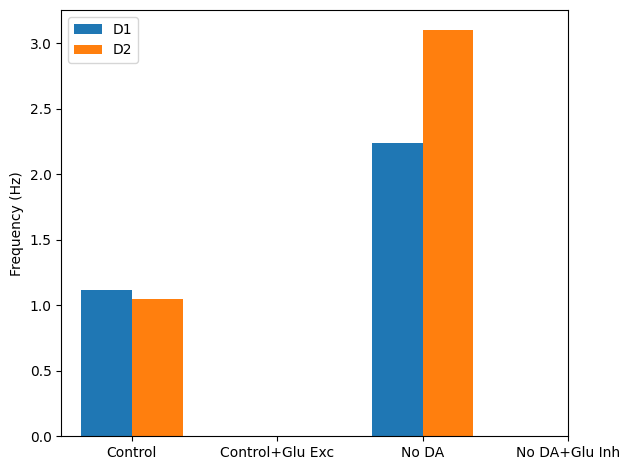

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming d1_firing_* and d2_firing_* are lists of firing rates
# Calculate means
mean_d1_ctl = np.mean(d1_firing_ctl)
mean_d2_ctl = np.mean(d2_firing_ctl)

mean_d1_glu = np.mean(d1_firing_glu)
mean_d2_glu = np.mean(d2_firing_glu)

mean_d1_pd = np.mean(d1_firing_pd)
mean_d2_pd = np.mean(d2_firing_pd)

mean_d1_pdr = np.mean(d1_firing_pdr)
mean_d2_pdr = np.mean(d2_firing_pdr)

# Data for bar chart
labels = ['Control', 'Control+Glu Exc', 'No DA', 'No DA+Glu Inh']
d1_means = [mean_d1_ctl, mean_d1_glu, mean_d1_pd, mean_d1_pdr]
d2_means = [mean_d2_ctl, mean_d2_glu, mean_d2_pd, mean_d2_pdr]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, d1_means, width, label='D1')
rects2 = ax.bar(x + width/2, d2_means, width, label='D2')

ax.set_ylabel('Frequency (Hz)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()
